In [114]:
print("hello")

hello


In [115]:
import os
import requests
from datetime import datetime, timedelta, timezone
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [116]:
os.getcwd()

'/home/soeren/Dokumente/Titan/Documents Repository/Publications/BDR-2020/Replication Package/execution-new/results-final'

In [117]:
exp_id = 1005
warmup_sec = 60
warmup_partitions_sec = 120
threshold = 2000 #slope


In [118]:
#exp_id = 35

#os.chdir("./results-final")

raw_runs = []

filenames = [filename for filename in os.listdir('.') if filename.startswith(f"exp{exp_id}") and filename.endswith("totallag.csv")]
for filename in filenames:
    #print(filename)
    run_params = filename[:-4].split("_")
    dim_value = run_params[2]
    instances = run_params[3]

    df = pd.read_csv(filename)
    #input = df.loc[df['topic'] == "input"]
    input = df
    #print(input)
    input['sec_start'] = input.loc[0:, 'timestamp'] - input.iloc[0]['timestamp']
    #print(input)
    #print(input.iloc[0, 'timestamp'])
    regress = input.loc[input['sec_start'] >= warmup_sec] # Warm-Up
    #regress = input

    #input.plot(kind='line',x='timestamp',y='value',color='red')
    #plt.show()

    X = regress.iloc[:, 2].values.reshape(-1, 1)  # values converts it into a numpy array
    Y = regress.iloc[:, 3].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor.predict(X)  # make predictions

    trend_slope = linear_regressor.coef_[0][0]
    #print(linear_regressor.coef_)

    row = {'dim_value': int(dim_value), 'instances': int(instances), 'trend_slope': trend_slope}
    #print(row)
    raw_runs.append(row)

lags = pd.DataFrame(raw_runs)


In [119]:
runs.head()

,dim_value,instances,trend_slope,partitions,obs_instances,failed,suitable
0,125000,1,112774.390209,363.951220,1.0,False,False
1,75000,2,2642.445854,400.000000,2.0,False,False
2,75000,1,59674.561013,400.000000,1.0,False,False
3,150000,1,148989.656842,340.769231,1.0,False,False
4,25000,4,-5.497205,400.000000,4.0,False,True


In [120]:

raw_partitions = []

filenames = [filename for filename in os.listdir('.') if filename.startswith(f"exp{exp_id}") and filename.endswith("partitions.csv")]
for filename in filenames:
    #print(filename)
    run_params = filename[:-4].split("_")
    dim_value = run_params[2]
    instances = run_params[3]

    df = pd.read_csv(filename)
    #input = df.loc[df['topic'] == "input"]
    input = df
    #print(input)
    input['sec_start'] = input.loc[0:, 'timestamp'] - input.iloc[0]['timestamp']
    #print(input)
    #print(input.iloc[0, 'timestamp'])
    input = input.loc[input['sec_start'] >= warmup_sec] # Warm-Up
    #regress = input

    input = input.loc[input['topic'] >= 'input']
    mean = input['value'].mean()

    #input.plot(kind='line',x='timestamp',y='value',color='red')
    #plt.show()


    row = {'dim_value': int(dim_value), 'instances': int(instances), 'partitions': mean}
    #print(row)
    raw_partitions.append(row)


partitions = pd.DataFrame(raw_partitions)

runs = lags.join(partitions.set_index(['dim_value', 'instances']), on=['dim_value', 'instances'])

In [121]:
raw_obs_instances = []

filenames = [filename for filename in os.listdir('.') if filename.startswith(f"exp{exp_id}") and filename.endswith("instances.csv")]
for filename in filenames:
    #print(filename)
    run_params = filename[:-4].split("_")
    dim_value = run_params[2]
    instances = run_params[3]

    df = pd.read_csv(filename)
    #input = df.loc[df['topic'] == "input"]
    input = df
    #print(input)
    input['sec_start'] = input.loc[0:, 'timestamp'] - input.iloc[0]['timestamp']
    #print(input)
    #print(input.iloc[0, 'timestamp'])
    input = input.loc[input['sec_start'] >= warmup_sec] # Warm-Up
    #regress = input

    #input = input.loc[input['topic'] >= 'input']
    mean = input['value'].mean()

    #input.plot(kind='line',x='timestamp',y='value',color='red')
    #plt.show()


    row = {'dim_value': int(dim_value), 'instances': int(instances), 'obs_instances': mean}
    #print(row)
    raw_obs_instances.append(row)


obs_instances = pd.DataFrame(raw_obs_instances)

obs_instances.head()

KeyError: 'timestamp'

In [122]:
runs = lags.join(partitions.set_index(['dim_value', 'instances']), on=['dim_value', 'instances']).join(obs_instances.set_index(['dim_value', 'instances']), on=['dim_value', 'instances'])

runs["failed"] = runs.apply(lambda row: (abs(row['instances'] - row['obs_instances']) / row['instances']) > 0.1, axis=1)

runs.loc[runs['failed']==True]

,dim_value,instances,trend_slope,partitions,obs_instances,failed


In [123]:
#threshold = 1000

# Set to true if the trend line has a slope less than 
runs["suitable"] =  runs.apply(lambda row: row['trend_slope'] < threshold, axis=1)

runs.columns = runs.columns.str.strip()
runs.sort_values(by=["dim_value", "instances"])

,dim_value,instances,trend_slope,partitions,obs_instances,failed,suitable
45,6,1,5561.487307,317.500000,NaN,False,False
29,6,2,13.596355,400.000000,NaN,False,True
18,6,3,96.702473,379.201342,NaN,False,True
24,6,4,6.537204,391.483871,NaN,False,True
3,6,6,0.767027,400.000000,NaN,False,True
33,6,8,-105.817580,395.090909,NaN,False,True
41,6,10,4.667027,395.200000,NaN,False,True
36,6,12,0.735857,395.200000,NaN,False,True
6,6,14,2.476956,395.200000,NaN,False,True
46,6,16,-4.115907,395.183333,NaN,False,True


In [124]:
filtered = runs[runs.apply(lambda x: x['suitable'], axis=1)]

grouped = filtered.groupby(['dim_value'])['instances'].min()
min_suitable_instances = grouped.to_frame().reset_index()

min_suitable_instances

,dim_value,instances
0,6,2
1,7,2
2,8,3
3,9,6


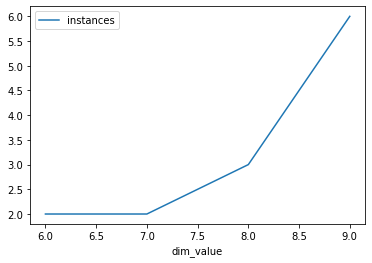

In [125]:
min_suitable_instances.plot(kind='line',x='dim_value',y='instances')
# min_suitable_instances.plot(kind='line',x='dim_value',y='instances', logy=True)

plt.show()